In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import requests
import tqdm
import os, h5py
import shutil
import re, glob
import cv2
import time
import logging

In [ ]:
tf.__version__

'2.12.0'

In [6]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

In [8]:
text_path = '/content/drive/MyDrive/data/srgan_img/curr_u_vector_230201_230531/'
root_path = '/content/drive/MyDrive/data/srgan_img/data'
img_path = '/content/drive/MyDrive/data/srgan_img/data/Train'

if os.path.exists(root_path) is False:
    os.mkdir(root_path)

if os.path.exists(img_path) is False:
    os.mkdir(img_path)

txtfiles = glob.glob(os.path.join(text_path, '*.txt'))


def mk_img(txt_file, save_path):

    save_name = txt_file.split('/')[-1].split('.')[0] + '.jpg'

    save_file = os.path.join(save_path,save_name)
    test_img = np.loadtxt(txt_file)

    test_img *= 255
    test_img[test_img[:] > 255] = 255
    test_img[test_img[:] < 0] = 0
    test_img = test_img.astype(np.uint8)

    dst = cv2.resize(test_img, dsize=(560, 420), interpolation=cv2.INTER_AREA)
    cv2.imwrite(save_file, dst)

for f in txtfiles:
    mk_img(txt_file=f, save_path=img_path)

In [131]:
DATA_PATH = "/content/drive/MyDrive/data/srgan_img/data/Train/"


scale = 4

def mk_train_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path + names[i]
        org_img = cv2.imread(name, cv2.IMREAD_COLOR)
        # org_img = cv2.cvtColor(org_img,  cv2.COLOR_BGR2YCrCb)
        h, w, c = org_img.shape

        new_height = int(h / scale)
        new_width = int(w / scale)

        lr_img = cv2.resize(org_img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

        re_img = cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC)

        lr_img = lr_img / 255.
        hr_img = org_img / 255.

        data.append(lr_img.astype('float32'))
        label.append(hr_img.astype('float32'))

    data = np.array(data, dtype='float32')
    label = np.array(label, dtype='float32')
    return data, label



def write_hdf5(data, labels, output_filename):

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)

def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))

        label = np.array(hf.get('label'))

        return data, label

if os.path.exists("/content/drive/MyDrive/data/srgan_img/data/train.h5") is False:
    data, label = mk_train_data(DATA_PATH)
    write_hdf5(data, label, "/content/drive/MyDrive/data/srgan_img/data/train.h5")
else:
    data, label = read_training_data(file='/content/drive/MyDrive/data/srgan_img/data/train.h5')
print(data.shape, label.shape)

(120, 105, 140, 3) (120, 420, 560, 3)


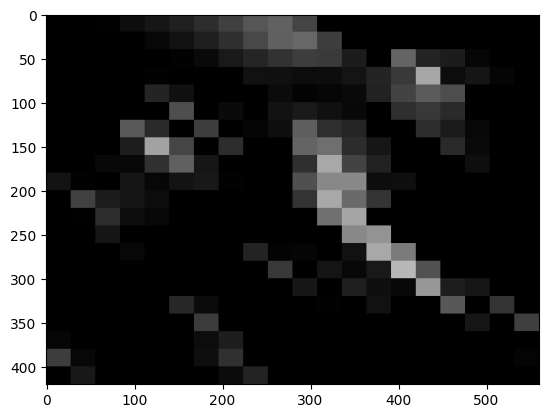

In [132]:
plt.imshow(label[10])

In [133]:
def bicubic_interpolate(image,shape):
    img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
    return img_resized

In [139]:
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
      ])
    return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes = input_conv

for x in range(5):
    res_output=residual_block_gen()(SRRes)
    SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)
SRRes=tf.keras.layers.Add()([SRRes,input_conv])

# for i in range(scale//2):
#     SRRes=Upsample_block(SRRes)

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)


output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

In [136]:
SRResnet.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_567 (Conv2D)            (None, None, None,   15616       ['input_46[0][0]']               
                                64)                                                               
                                                                                                  
 leaky_re_lu_506 (LeakyReLU)    (None, None, None,   0           ['conv2d_567[0][0]']             
                                64)                                                        

In [137]:
def residual_block_disc(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
      ])
    return model

input_lr=tf.keras.layers.Input(shape=(420, 560,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same', input_shape=(None,None,1))(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv

for x in range(7):
    disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)

disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

In [138]:
discriminator.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 420, 560, 3)]     0         
                                                                 
 conv2d_583 (Conv2D)         (None, 420, 560, 64)      1792      
                                                                 
 leaky_re_lu_520 (LeakyReLU)  (None, 420, 560, 64)     0         
                                                                 
 sequential_218 (Sequential)  (None, 210, 280, 64)     37184     
                                                                 
 sequential_219 (Sequential)  (None, 210, 280, 128)    74368     
                                                                 
 sequential_220 (Sequential)  (None, 105, 140, 128)    148096    
                                                                 
 sequential_221 (Sequential)  (None, 105, 140, 256)    296

In [140]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1 / (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [141]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(420, 560,3))

VGG_i,VGG_j=2,2

def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
    i,j=0,0
    accumulated_loss=0.0
    for l in VGG19.layers:
        cl_name=l.__class__.__name__
        if cl_name=='Conv2D':
            j+=1
        if cl_name=='MaxPooling2D':
            i+=1
            j=0
        if i==i_m and j==j_m:
            break

    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
        accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

    return accumulated_loss


def VGG_loss_intuitive(y_true,y_pred):
    accumulated_loss=0.0
    for l in VGG19.layers:
        y_true=l(y_true)
        y_pred=l(y_pred)
        accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
    return accumulated_loss

In [142]:
generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
# MSE
loss_func,adv_learning = pixel_MSE,False
# VGG2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# SRGAN-MSE
loss_func,adv_learning = pixel_MSE,True
# # SRGAN-VGG 2.2
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# # # SRGAN-VGG 5.4
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

# # #Real loss
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

In [143]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function()
def train_step(lr_data, hr_data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.1):
    logs = {}
    gen_loss,disc_loss=0,0

    low_resolution, high_resolution = lr_data, hr_data

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        super_resolution = SRResnet(low_resolution, training=True)
        gen_loss=loss_func(high_resolution,super_resolution)

        logs['reconstruction']=gen_loss

        if adv_learning:
            real_output = discriminator(high_resolution, training=True)
            fake_output = discriminator(super_resolution, training=True)

            adv_loss_g = generator_loss(fake_output) * adv_ratio
            gen_loss += adv_loss_g

            disc_loss = discriminator_loss(real_output, fake_output)
            logs['adv_g']=adv_loss_g
            logs['adv_d']=disc_loss


    gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))

    if adv_learning:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    for x in evaluate:
        if x=='PSNR':
            logs[x]=PSNR(high_resolution,super_resolution)

    return logs

In [144]:
data.shape

(120, 105, 140, 3)

In [145]:
for x in range(2):
    lr_data, hr_data = data, label
    for lr, hr in tqdm.tqdm(zip(data, label)):
        lr = tf.expand_dims(lr, axis=0)
        # lr = np.reshape(lr, (1,64,64,1))
        hr = tf.expand_dims(hr, axis=0)
        # hr = np.reshape(hr, (1,128,128,1))

        logs=train_step(lr,hr,loss_func,adv_learning,evaluate,adv_ratio)
        for k in logs.keys():
            print(k,':',logs[k],end='  ')
    print()

1it [00:20, 20.43s/it]

reconstruction : tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0011584158, shape=(), dtype=float32)  adv_d : tf.Tensor(1.8898144, shape=(), dtype=float32)  PSNR : tf.Tensor(12.421357, shape=(), dtype=float32)  reconstruction : 

2it [00:20,  8.60s/it]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00053206313, shape=(), dtype=float32)  adv_d : tf.Tensor(1.8082026, shape=(), dtype=float32)  PSNR : tf.Tensor(12.74594, shape=(), dtype=float32)  reconstruction : 

3it [00:21,  4.82s/it]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012285136, shape=(), dtype=float32)  adv_d : tf.Tensor(8.7656745e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.54928, shape=(), dtype=float32)  reconstruction : 

4it [00:21,  3.04s/it]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011289683, shape=(), dtype=float32)  adv_d : tf.Tensor(1.8495051e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.141097, shape=(), dtype=float32)  reconstruction : 

5it [00:21,  2.06s/it]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010160432, shape=(), dtype=float32)  adv_d : tf.Tensor(4.9567177e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.94303, shape=(), dtype=float32)  reconstruction : 

6it [00:22,  1.47s/it]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008576544, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0002251175, shape=(), dtype=float32)  PSNR : tf.Tensor(11.92234, shape=(), dtype=float32)  reconstruction : 

7it [00:22,  1.09s/it]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007341562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0007707379, shape=(), dtype=float32)  PSNR : tf.Tensor(12.294783, shape=(), dtype=float32)  reconstruction : 

8it [00:22,  1.18it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031655862, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04892296, shape=(), dtype=float32)  PSNR : tf.Tensor(12.5050125, shape=(), dtype=float32)  reconstruction : 

9it [00:22,  1.47it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024597186, shape=(), dtype=float32)  adv_d : tf.Tensor(0.5375051, shape=(), dtype=float32)  PSNR : tf.Tensor(12.883216, shape=(), dtype=float32)  reconstruction : 

10it [00:23,  1.75it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0020569814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14280865, shape=(), dtype=float32)  PSNR : tf.Tensor(12.293109, shape=(), dtype=float32)  reconstruction : 

11it [00:23,  2.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039179763, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07366003, shape=(), dtype=float32)  PSNR : tf.Tensor(11.501721, shape=(), dtype=float32)  reconstruction : 

12it [00:23,  2.27it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024522457, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11848107, shape=(), dtype=float32)  PSNR : tf.Tensor(10.460107, shape=(), dtype=float32)  reconstruction : 

13it [00:24,  2.47it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003446951, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054238446, shape=(), dtype=float32)  PSNR : tf.Tensor(9.865207, shape=(), dtype=float32)  reconstruction : 

14it [00:24,  2.64it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029959052, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08374365, shape=(), dtype=float32)  PSNR : tf.Tensor(10.260128, shape=(), dtype=float32)  reconstruction : 

15it [00:24,  2.77it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031286129, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18957534, shape=(), dtype=float32)  PSNR : tf.Tensor(12.70171, shape=(), dtype=float32)  reconstruction : 

16it [00:25,  2.86it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009184383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00010508052, shape=(), dtype=float32)  PSNR : tf.Tensor(12.883446, shape=(), dtype=float32)  reconstruction : 

17it [00:25,  2.95it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012154152, shape=(), dtype=float32)  adv_d : tf.Tensor(6.332599e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.138097, shape=(), dtype=float32)  reconstruction : 

18it [00:25,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012065518, shape=(), dtype=float32)  adv_d : tf.Tensor(7.069277e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(11.700128, shape=(), dtype=float32)  reconstruction : 

19it [00:26,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010806353, shape=(), dtype=float32)  adv_d : tf.Tensor(2.2345335e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.201231, shape=(), dtype=float32)  reconstruction : 

20it [00:26,  3.07it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009301789, shape=(), dtype=float32)  adv_d : tf.Tensor(9.526434e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(10.912974, shape=(), dtype=float32)  reconstruction : 

21it [00:26,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008369376, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00023752646, shape=(), dtype=float32)  PSNR : tf.Tensor(11.245665, shape=(), dtype=float32)  reconstruction : 

22it [00:27,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006766462, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0011604743, shape=(), dtype=float32)  PSNR : tf.Tensor(11.772599, shape=(), dtype=float32)  reconstruction : 

23it [00:27,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051435586, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059016873, shape=(), dtype=float32)  PSNR : tf.Tensor(12.360878, shape=(), dtype=float32)  reconstruction : 

24it [00:27,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068539195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046899198, shape=(), dtype=float32)  PSNR : tf.Tensor(11.671189, shape=(), dtype=float32)  reconstruction : 

25it [00:28,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006174509, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036620428, shape=(), dtype=float32)  PSNR : tf.Tensor(10.074535, shape=(), dtype=float32)  reconstruction : 

26it [00:28,  3.12it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054790806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058544176, shape=(), dtype=float32)  PSNR : tf.Tensor(9.763519, shape=(), dtype=float32)  reconstruction : 

27it [00:28,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050462577, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007323652, shape=(), dtype=float32)  PSNR : tf.Tensor(10.053261, shape=(), dtype=float32)  reconstruction : 

28it [00:29,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003839342, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02557578, shape=(), dtype=float32)  PSNR : tf.Tensor(11.244634, shape=(), dtype=float32)  reconstruction : 

29it [00:29,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00402177, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018435648, shape=(), dtype=float32)  PSNR : tf.Tensor(12.479218, shape=(), dtype=float32)  reconstruction : 

30it [00:29,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011659951, shape=(), dtype=float32)  adv_d : tf.Tensor(9.947877e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.974968, shape=(), dtype=float32)  reconstruction : 

31it [00:30,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012185004, shape=(), dtype=float32)  adv_d : tf.Tensor(6.026602e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.711285, shape=(), dtype=float32)  reconstruction : 

32it [00:30,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012340304, shape=(), dtype=float32)  adv_d : tf.Tensor(5.4264983e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.690514, shape=(), dtype=float32)  reconstruction : 

33it [00:30,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012175507, shape=(), dtype=float32)  adv_d : tf.Tensor(6.1008864e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.520913, shape=(), dtype=float32)  reconstruction : 

34it [00:30,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011124655, shape=(), dtype=float32)  adv_d : tf.Tensor(1.6061016e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.047047, shape=(), dtype=float32)  reconstruction : 

35it [00:31,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00995, shape=(), dtype=float32)  adv_d : tf.Tensor(5.0032562e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.562442, shape=(), dtype=float32)  reconstruction : 

36it [00:31,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008935486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00013637225, shape=(), dtype=float32)  PSNR : tf.Tensor(11.841522, shape=(), dtype=float32)  reconstruction : 

37it [00:31,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007571375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00052536634, shape=(), dtype=float32)  PSNR : tf.Tensor(12.106821, shape=(), dtype=float32)  reconstruction : 

38it [00:32,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045643006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010487618, shape=(), dtype=float32)  PSNR : tf.Tensor(12.517972, shape=(), dtype=float32)  reconstruction : 

39it [00:32,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006237175, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024595484, shape=(), dtype=float32)  PSNR : tf.Tensor(12.5693445, shape=(), dtype=float32)  reconstruction : 

40it [00:32,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071490207, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005168189, shape=(), dtype=float32)  PSNR : tf.Tensor(11.647227, shape=(), dtype=float32)  reconstruction : 

41it [00:33,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065295985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0031029386, shape=(), dtype=float32)  PSNR : tf.Tensor(10.476834, shape=(), dtype=float32)  reconstruction : 

42it [00:33,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006320383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0029159493, shape=(), dtype=float32)  PSNR : tf.Tensor(9.873966, shape=(), dtype=float32)  reconstruction : 

43it [00:33,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056188833, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004962034, shape=(), dtype=float32)  PSNR : tf.Tensor(10.008811, shape=(), dtype=float32)  reconstruction : 

44it [00:34,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031984888, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050236758, shape=(), dtype=float32)  PSNR : tf.Tensor(13.014612, shape=(), dtype=float32)  reconstruction : 

45it [00:34,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007946354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00036295172, shape=(), dtype=float32)  PSNR : tf.Tensor(13.353552, shape=(), dtype=float32)  reconstruction : 

46it [00:34,  3.13it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011959892, shape=(), dtype=float32)  adv_d : tf.Tensor(7.559056e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.281367, shape=(), dtype=float32)  reconstruction : 

47it [00:35,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012485582, shape=(), dtype=float32)  adv_d : tf.Tensor(5.1538595e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(11.809227, shape=(), dtype=float32)  reconstruction : 

48it [00:35,  3.14it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012478677, shape=(), dtype=float32)  adv_d : tf.Tensor(5.340953e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(11.768295, shape=(), dtype=float32)  reconstruction : 

49it [00:35,  3.12it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010467386, shape=(), dtype=float32)  adv_d : tf.Tensor(3.1130683e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.272516, shape=(), dtype=float32)  reconstruction : 

50it [00:36,  3.12it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008953312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00013353, shape=(), dtype=float32)  PSNR : tf.Tensor(11.318974, shape=(), dtype=float32)  reconstruction : 

51it [00:36,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007992318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00034755355, shape=(), dtype=float32)  PSNR : tf.Tensor(11.566314, shape=(), dtype=float32)  reconstruction : 

52it [00:36,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004699677, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009154891, shape=(), dtype=float32)  PSNR : tf.Tensor(12.352859, shape=(), dtype=float32)  reconstruction : 

53it [00:37,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006814702, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0023301402, shape=(), dtype=float32)  PSNR : tf.Tensor(12.493247, shape=(), dtype=float32)  reconstruction : 

54it [00:37,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071188677, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034294277, shape=(), dtype=float32)  PSNR : tf.Tensor(11.279141, shape=(), dtype=float32)  reconstruction : 

55it [00:37,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007111186, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024146833, shape=(), dtype=float32)  PSNR : tf.Tensor(10.558246, shape=(), dtype=float32)  reconstruction : 

56it [00:38,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066382345, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0018418196, shape=(), dtype=float32)  PSNR : tf.Tensor(10.459551, shape=(), dtype=float32)  reconstruction : 

57it [00:38,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058004777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00451968, shape=(), dtype=float32)  PSNR : tf.Tensor(11.3031025, shape=(), dtype=float32)  reconstruction : 

58it [00:38,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041781873, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025582073, shape=(), dtype=float32)  PSNR : tf.Tensor(13.281182, shape=(), dtype=float32)  reconstruction : 

59it [00:38,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009374887, shape=(), dtype=float32)  adv_d : tf.Tensor(9.0237256e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(13.577913, shape=(), dtype=float32)  reconstruction : 

60it [00:39,  3.08it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011791118, shape=(), dtype=float32)  adv_d : tf.Tensor(8.96532e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(13.011026, shape=(), dtype=float32)  reconstruction : 

61it [00:39,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012310998, shape=(), dtype=float32)  adv_d : tf.Tensor(5.6094404e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.858897, shape=(), dtype=float32)  reconstruction : 

62it [00:39,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0121536, shape=(), dtype=float32)  adv_d : tf.Tensor(6.7668293e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.75103, shape=(), dtype=float32)  reconstruction : 

63it [00:40,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011697146, shape=(), dtype=float32)  adv_d : tf.Tensor(9.482497e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.661959, shape=(), dtype=float32)  reconstruction : 

64it [00:40,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0115564205, shape=(), dtype=float32)  adv_d : tf.Tensor(1.1434959e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.790662, shape=(), dtype=float32)  reconstruction : 

65it [00:40,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009960056, shape=(), dtype=float32)  adv_d : tf.Tensor(5.0965205e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.314252, shape=(), dtype=float32)  reconstruction : 

66it [00:41,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008615648, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00018948074, shape=(), dtype=float32)  PSNR : tf.Tensor(11.53687, shape=(), dtype=float32)  reconstruction : 

67it [00:41,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00712373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00082357007, shape=(), dtype=float32)  PSNR : tf.Tensor(11.706465, shape=(), dtype=float32)  reconstruction : 

68it [00:41,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005741509, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0032676097, shape=(), dtype=float32)  PSNR : tf.Tensor(12.414187, shape=(), dtype=float32)  reconstruction : 

69it [00:42,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074254856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035201726, shape=(), dtype=float32)  PSNR : tf.Tensor(11.936619, shape=(), dtype=float32)  reconstruction : 

70it [00:42,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076226974, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0022195322, shape=(), dtype=float32)  PSNR : tf.Tensor(10.669566, shape=(), dtype=float32)  reconstruction : 

71it [00:42,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006830204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0017853037, shape=(), dtype=float32)  PSNR : tf.Tensor(9.9805975, shape=(), dtype=float32)  reconstruction : 

72it [00:43,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064864783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0022765612, shape=(), dtype=float32)  PSNR : tf.Tensor(10.23384, shape=(), dtype=float32)  reconstruction : 

73it [00:43,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005186721, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009384584, shape=(), dtype=float32)  PSNR : tf.Tensor(12.245962, shape=(), dtype=float32)  reconstruction : 

74it [00:43,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007530154, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0005539654, shape=(), dtype=float32)  PSNR : tf.Tensor(12.257953, shape=(), dtype=float32)  reconstruction : 

75it [00:44,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.01101781, shape=(), dtype=float32)  adv_d : tf.Tensor(1.7671238e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.356579, shape=(), dtype=float32)  reconstruction : 

76it [00:44,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012091391, shape=(), dtype=float32)  adv_d : tf.Tensor(6.8174263e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.078292, shape=(), dtype=float32)  reconstruction : 

77it [00:44,  3.11it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0120059885, shape=(), dtype=float32)  adv_d : tf.Tensor(7.4964296e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.025728, shape=(), dtype=float32)  reconstruction : 

78it [00:45,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011694478, shape=(), dtype=float32)  adv_d : tf.Tensor(1.0037513e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.805755, shape=(), dtype=float32)  reconstruction : 

79it [00:45,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010329584, shape=(), dtype=float32)  adv_d : tf.Tensor(3.481107e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.652688, shape=(), dtype=float32)  reconstruction : 

80it [00:45,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008928583, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00013950292, shape=(), dtype=float32)  PSNR : tf.Tensor(11.772773, shape=(), dtype=float32)  reconstruction : 

81it [00:46,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072981827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0006929423, shape=(), dtype=float32)  PSNR : tf.Tensor(12.752828, shape=(), dtype=float32)  reconstruction : 

82it [00:46,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059136064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027814251, shape=(), dtype=float32)  PSNR : tf.Tensor(12.759599, shape=(), dtype=float32)  reconstruction : 

83it [00:46,  3.10it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077753994, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002494454, shape=(), dtype=float32)  PSNR : tf.Tensor(12.175672, shape=(), dtype=float32)  reconstruction : 

84it [00:47,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075551635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0017488131, shape=(), dtype=float32)  PSNR : tf.Tensor(11.8843565, shape=(), dtype=float32)  reconstruction : 

85it [00:47,  3.09it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070919013, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016125599, shape=(), dtype=float32)  PSNR : tf.Tensor(9.800696, shape=(), dtype=float32)  reconstruction : 

86it [00:47,  3.08it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065478664, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0021409197, shape=(), dtype=float32)  PSNR : tf.Tensor(11.160394, shape=(), dtype=float32)  reconstruction : 

87it [00:48,  3.08it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054582832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075623915, shape=(), dtype=float32)  PSNR : tf.Tensor(12.634209, shape=(), dtype=float32)  reconstruction : 

88it [00:48,  3.08it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064660567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0021253119, shape=(), dtype=float32)  PSNR : tf.Tensor(12.528262, shape=(), dtype=float32)  reconstruction : 

89it [00:48,  3.08it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008829046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00014881887, shape=(), dtype=float32)  PSNR : tf.Tensor(12.78476, shape=(), dtype=float32)  reconstruction : 

90it [00:49,  3.08it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012441409, shape=(), dtype=float32)  adv_d : tf.Tensor(5.05796e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.929648, shape=(), dtype=float32)  reconstruction : 

91it [00:49,  3.08it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012541121, shape=(), dtype=float32)  adv_d : tf.Tensor(4.8227807e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.678978, shape=(), dtype=float32)  reconstruction : 

92it [00:49,  3.07it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011777071, shape=(), dtype=float32)  adv_d : tf.Tensor(9.5679925e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(13.041095, shape=(), dtype=float32)  reconstruction : 

93it [00:49,  3.07it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011291145, shape=(), dtype=float32)  adv_d : tf.Tensor(1.4083967e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.948697, shape=(), dtype=float32)  reconstruction : 

94it [00:50,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.01156453, shape=(), dtype=float32)  adv_d : tf.Tensor(1.1095575e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.082311, shape=(), dtype=float32)  reconstruction : 

95it [00:50,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009721768, shape=(), dtype=float32)  adv_d : tf.Tensor(6.294407e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.04374, shape=(), dtype=float32)  reconstruction : 

96it [00:50,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007896644, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00038338872, shape=(), dtype=float32)  PSNR : tf.Tensor(12.61666, shape=(), dtype=float32)  reconstruction : 

97it [00:51,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059114844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027415308, shape=(), dtype=float32)  PSNR : tf.Tensor(12.5759535, shape=(), dtype=float32)  reconstruction : 

98it [00:51,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007729097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027174682, shape=(), dtype=float32)  PSNR : tf.Tensor(11.987052, shape=(), dtype=float32)  reconstruction : 

99it [00:51,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007444315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0019804626, shape=(), dtype=float32)  PSNR : tf.Tensor(10.53983, shape=(), dtype=float32)  reconstruction : 

100it [00:52,  3.04it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071994993, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0015218493, shape=(), dtype=float32)  PSNR : tf.Tensor(9.701692, shape=(), dtype=float32)  reconstruction : 

101it [00:52,  3.04it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066234404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0021378852, shape=(), dtype=float32)  PSNR : tf.Tensor(9.597896, shape=(), dtype=float32)  reconstruction : 

102it [00:52,  3.04it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054549375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005997459, shape=(), dtype=float32)  PSNR : tf.Tensor(10.569701, shape=(), dtype=float32)  reconstruction : 

103it [00:53,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005331304, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005947708, shape=(), dtype=float32)  PSNR : tf.Tensor(12.064815, shape=(), dtype=float32)  reconstruction : 

104it [00:53,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009544246, shape=(), dtype=float32)  adv_d : tf.Tensor(7.4979405e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.623696, shape=(), dtype=float32)  reconstruction : 

105it [00:53,  3.05it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011420839, shape=(), dtype=float32)  adv_d : tf.Tensor(1.2470681e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.207585, shape=(), dtype=float32)  reconstruction : 

106it [00:54,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012180048, shape=(), dtype=float32)  adv_d : tf.Tensor(6.6721436e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.407342, shape=(), dtype=float32)  reconstruction : 

107it [00:54,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0111667, shape=(), dtype=float32)  adv_d : tf.Tensor(1.608939e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(13.070252, shape=(), dtype=float32)  reconstruction : 

108it [00:54,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010185212, shape=(), dtype=float32)  adv_d : tf.Tensor(3.9337305e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.581936, shape=(), dtype=float32)  reconstruction : 

109it [00:55,  3.07it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008211183, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00027697292, shape=(), dtype=float32)  PSNR : tf.Tensor(12.722926, shape=(), dtype=float32)  reconstruction : 

110it [00:55,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006502269, shape=(), dtype=float32)  adv_d : tf.Tensor(0.001532326, shape=(), dtype=float32)  PSNR : tf.Tensor(12.634695, shape=(), dtype=float32)  reconstruction : 

111it [00:55,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051092072, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061107916, shape=(), dtype=float32)  PSNR : tf.Tensor(12.594876, shape=(), dtype=float32)  reconstruction : 

112it [00:56,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077439137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0020398442, shape=(), dtype=float32)  PSNR : tf.Tensor(12.158668, shape=(), dtype=float32)  reconstruction : 

113it [00:56,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007609272, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002312528, shape=(), dtype=float32)  PSNR : tf.Tensor(11.351073, shape=(), dtype=float32)  reconstruction : 

114it [00:56,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007653037, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0010991088, shape=(), dtype=float32)  PSNR : tf.Tensor(10.577217, shape=(), dtype=float32)  reconstruction : 

115it [00:57,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007183103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0010955276, shape=(), dtype=float32)  PSNR : tf.Tensor(10.133563, shape=(), dtype=float32)  reconstruction : 

116it [00:57,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072237374, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0014285885, shape=(), dtype=float32)  PSNR : tf.Tensor(10.579733, shape=(), dtype=float32)  reconstruction : 

117it [00:57,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005709511, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056555695, shape=(), dtype=float32)  PSNR : tf.Tensor(11.036097, shape=(), dtype=float32)  reconstruction : 

118it [00:58,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00615504, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038766714, shape=(), dtype=float32)  PSNR : tf.Tensor(11.86806, shape=(), dtype=float32)  reconstruction : 

119it [00:58,  3.06it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0082652485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00026060318, shape=(), dtype=float32)  PSNR : tf.Tensor(13.040115, shape=(), dtype=float32)  reconstruction : 

120it [00:58,  2.04it/s]


tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011240157, shape=(), dtype=float32)  adv_d : tf.Tensor(1.6679245e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(13.335276, shape=(), dtype=float32)  


0it [00:00, ?it/s]

reconstruction : 

1it [00:00,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006770642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0011476749, shape=(), dtype=float32)  PSNR : tf.Tensor(12.424026, shape=(), dtype=float32)  reconstruction : 

2it [00:00,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.01318091, shape=(), dtype=float32)  adv_d : tf.Tensor(2.8169047e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.749298, shape=(), dtype=float32)  reconstruction : 

3it [00:00,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012699445, shape=(), dtype=float32)  adv_d : tf.Tensor(4.213329e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.551976, shape=(), dtype=float32)  reconstruction : 

4it [00:01,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011812166, shape=(), dtype=float32)  adv_d : tf.Tensor(8.784868e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.143196, shape=(), dtype=float32)  reconstruction : 

5it [00:01,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010845002, shape=(), dtype=float32)  adv_d : tf.Tensor(2.1319021e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.944508, shape=(), dtype=float32)  reconstruction : 

6it [00:01,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009475585, shape=(), dtype=float32)  adv_d : tf.Tensor(8.097871e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.923546, shape=(), dtype=float32)  reconstruction : 

7it [00:02,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008630228, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00018577749, shape=(), dtype=float32)  PSNR : tf.Tensor(12.296425, shape=(), dtype=float32)  reconstruction : 

8it [00:02,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006005624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024838296, shape=(), dtype=float32)  PSNR : tf.Tensor(12.509005, shape=(), dtype=float32)  reconstruction : 

9it [00:02,  3.04it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006451851, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016010705, shape=(), dtype=float32)  PSNR : tf.Tensor(12.888995, shape=(), dtype=float32)  reconstruction : 

10it [00:03,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0078659775, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016166802, shape=(), dtype=float32)  PSNR : tf.Tensor(12.296046, shape=(), dtype=float32)  reconstruction : 

11it [00:03,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008119903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0014624246, shape=(), dtype=float32)  PSNR : tf.Tensor(11.5027895, shape=(), dtype=float32)  reconstruction : 

12it [00:03,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008105568, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0009940354, shape=(), dtype=float32)  PSNR : tf.Tensor(10.460308, shape=(), dtype=float32)  reconstruction : 

13it [00:04,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075956555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0009210835, shape=(), dtype=float32)  PSNR : tf.Tensor(9.864979, shape=(), dtype=float32)  reconstruction : 

14it [00:04,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00692762, shape=(), dtype=float32)  adv_d : tf.Tensor(0.001647872, shape=(), dtype=float32)  PSNR : tf.Tensor(10.260497, shape=(), dtype=float32)  reconstruction : 

15it [00:04,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006237964, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038475962, shape=(), dtype=float32)  PSNR : tf.Tensor(12.705207, shape=(), dtype=float32)  reconstruction : 

16it [00:05,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009781715, shape=(), dtype=float32)  adv_d : tf.Tensor(5.965967e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.888077, shape=(), dtype=float32)  reconstruction : 

17it [00:05,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012539274, shape=(), dtype=float32)  adv_d : tf.Tensor(5.0064145e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.140704, shape=(), dtype=float32)  reconstruction : 

18it [00:05,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.01240871, shape=(), dtype=float32)  adv_d : tf.Tensor(5.8396467e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(11.701959, shape=(), dtype=float32)  reconstruction : 

19it [00:06,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011231773, shape=(), dtype=float32)  adv_d : tf.Tensor(1.6076829e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.202783, shape=(), dtype=float32)  reconstruction : 

20it [00:06,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009796138, shape=(), dtype=float32)  adv_d : tf.Tensor(6.119049e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(10.914297, shape=(), dtype=float32)  reconstruction : 

21it [00:06,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008973778, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00013446176, shape=(), dtype=float32)  PSNR : tf.Tensor(11.246308, shape=(), dtype=float32)  reconstruction : 

22it [00:07,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007631637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00049553555, shape=(), dtype=float32)  PSNR : tf.Tensor(11.774256, shape=(), dtype=float32)  reconstruction : 

23it [00:07,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063770018, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0017486019, shape=(), dtype=float32)  PSNR : tf.Tensor(12.365467, shape=(), dtype=float32)  reconstruction : 

24it [00:07,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007881954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002409385, shape=(), dtype=float32)  PSNR : tf.Tensor(11.673031, shape=(), dtype=float32)  reconstruction : 

25it [00:08,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007918045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0010391609, shape=(), dtype=float32)  PSNR : tf.Tensor(10.074664, shape=(), dtype=float32)  reconstruction : 

26it [00:08,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074877846, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0012779386, shape=(), dtype=float32)  PSNR : tf.Tensor(9.763159, shape=(), dtype=float32)  reconstruction : 

27it [00:08,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073960396, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0010021109, shape=(), dtype=float32)  PSNR : tf.Tensor(10.053323, shape=(), dtype=float32)  reconstruction : 

28it [00:09,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064468756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033228353, shape=(), dtype=float32)  PSNR : tf.Tensor(11.245884, shape=(), dtype=float32)  reconstruction : 

29it [00:09,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058446033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0031574434, shape=(), dtype=float32)  PSNR : tf.Tensor(12.484091, shape=(), dtype=float32)  reconstruction : 

30it [00:09,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011950285, shape=(), dtype=float32)  adv_d : tf.Tensor(8.088457e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.979601, shape=(), dtype=float32)  reconstruction : 

31it [00:10,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012379728, shape=(), dtype=float32)  adv_d : tf.Tensor(5.3346585e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.714958, shape=(), dtype=float32)  reconstruction : 

32it [00:10,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012529042, shape=(), dtype=float32)  adv_d : tf.Tensor(4.9219307e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.693366, shape=(), dtype=float32)  reconstruction : 

33it [00:10,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012365054, shape=(), dtype=float32)  adv_d : tf.Tensor(5.4383263e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.523479, shape=(), dtype=float32)  reconstruction : 

34it [00:11,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011352544, shape=(), dtype=float32)  adv_d : tf.Tensor(1.3388395e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.048918, shape=(), dtype=float32)  reconstruction : 

35it [00:11,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010255071, shape=(), dtype=float32)  adv_d : tf.Tensor(3.8090995e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.563435, shape=(), dtype=float32)  reconstruction : 

36it [00:11,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009373066, shape=(), dtype=float32)  adv_d : tf.Tensor(9.0905145e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.842731, shape=(), dtype=float32)  reconstruction : 

37it [00:12,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008224935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00028046142, shape=(), dtype=float32)  PSNR : tf.Tensor(12.108849, shape=(), dtype=float32)  reconstruction : 

38it [00:12,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056637577, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034927176, shape=(), dtype=float32)  PSNR : tf.Tensor(12.522554, shape=(), dtype=float32)  reconstruction : 

39it [00:12,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006966439, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0013040552, shape=(), dtype=float32)  PSNR : tf.Tensor(12.574147, shape=(), dtype=float32)  reconstruction : 

40it [00:13,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007855061, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024173413, shape=(), dtype=float32)  PSNR : tf.Tensor(11.649279, shape=(), dtype=float32)  reconstruction : 

41it [00:13,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007685632, shape=(), dtype=float32)  adv_d : tf.Tensor(0.001127949, shape=(), dtype=float32)  PSNR : tf.Tensor(10.4773245, shape=(), dtype=float32)  reconstruction : 

42it [00:13,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00771011, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0009036731, shape=(), dtype=float32)  PSNR : tf.Tensor(9.873629, shape=(), dtype=float32)  reconstruction : 

43it [00:14,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007291191, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0012383576, shape=(), dtype=float32)  PSNR : tf.Tensor(10.008878, shape=(), dtype=float32)  reconstruction : 

44it [00:14,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052675335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009083625, shape=(), dtype=float32)  PSNR : tf.Tensor(13.016908, shape=(), dtype=float32)  reconstruction : 

45it [00:14,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008242695, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00027290627, shape=(), dtype=float32)  PSNR : tf.Tensor(13.35928, shape=(), dtype=float32)  reconstruction : 

46it [00:15,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0121002775, shape=(), dtype=float32)  adv_d : tf.Tensor(6.8919935e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.284615, shape=(), dtype=float32)  reconstruction : 

47it [00:15,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012553281, shape=(), dtype=float32)  adv_d : tf.Tensor(5.1267984e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(11.811166, shape=(), dtype=float32)  reconstruction : 

48it [00:15,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012541043, shape=(), dtype=float32)  adv_d : tf.Tensor(5.3613016e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(11.770207, shape=(), dtype=float32)  reconstruction : 

49it [00:16,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010610155, shape=(), dtype=float32)  adv_d : tf.Tensor(2.7833956e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.273789, shape=(), dtype=float32)  reconstruction : 

50it [00:16,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009200037, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00010604321, shape=(), dtype=float32)  PSNR : tf.Tensor(11.319621, shape=(), dtype=float32)  reconstruction : 

51it [00:16,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008370946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0002425177, shape=(), dtype=float32)  PSNR : tf.Tensor(11.567361, shape=(), dtype=float32)  reconstruction : 

52it [00:17,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054964437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041252673, shape=(), dtype=float32)  PSNR : tf.Tensor(12.356851, shape=(), dtype=float32)  reconstruction : 

53it [00:17,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073240413, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0014849612, shape=(), dtype=float32)  PSNR : tf.Tensor(12.497405, shape=(), dtype=float32)  reconstruction : 

54it [00:17,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007649364, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016277015, shape=(), dtype=float32)  PSNR : tf.Tensor(11.280543, shape=(), dtype=float32)  reconstruction : 

55it [00:18,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007824428, shape=(), dtype=float32)  adv_d : tf.Tensor(0.001030705, shape=(), dtype=float32)  PSNR : tf.Tensor(10.558479, shape=(), dtype=float32)  reconstruction : 

56it [00:18,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075065163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.000764449, shape=(), dtype=float32)  PSNR : tf.Tensor(10.459659, shape=(), dtype=float32)  reconstruction : 

57it [00:18,  2.97it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006898329, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016152605, shape=(), dtype=float32)  PSNR : tf.Tensor(11.304254, shape=(), dtype=float32)  reconstruction : 

58it [00:19,  2.95it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00524642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010078805, shape=(), dtype=float32)  PSNR : tf.Tensor(13.285775, shape=(), dtype=float32)  reconstruction : 

59it [00:19,  2.94it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009495765, shape=(), dtype=float32)  adv_d : tf.Tensor(8.1179496e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(13.582504, shape=(), dtype=float32)  reconstruction : 

60it [00:20,  2.96it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0118283285, shape=(), dtype=float32)  adv_d : tf.Tensor(8.865793e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(13.0138, shape=(), dtype=float32)  reconstruction : 

61it [00:20,  2.94it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0123130195, shape=(), dtype=float32)  adv_d : tf.Tensor(5.7374373e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.86166, shape=(), dtype=float32)  reconstruction : 

62it [00:20,  2.94it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012162663, shape=(), dtype=float32)  adv_d : tf.Tensor(6.910961e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.753498, shape=(), dtype=float32)  reconstruction : 

63it [00:21,  2.94it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011715024, shape=(), dtype=float32)  adv_d : tf.Tensor(9.494275e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.664384, shape=(), dtype=float32)  reconstruction : 

64it [00:21,  2.96it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011570178, shape=(), dtype=float32)  adv_d : tf.Tensor(1.1567475e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.792164, shape=(), dtype=float32)  reconstruction : 

65it [00:21,  2.95it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010087655, shape=(), dtype=float32)  adv_d : tf.Tensor(4.5865574e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.315014, shape=(), dtype=float32)  reconstruction : 

66it [00:22,  2.95it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008856503, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00015180113, shape=(), dtype=float32)  PSNR : tf.Tensor(11.537509, shape=(), dtype=float32)  reconstruction : 

67it [00:22,  2.96it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007561941, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0005388865, shape=(), dtype=float32)  PSNR : tf.Tensor(11.709383, shape=(), dtype=float32)  reconstruction : 

68it [00:22,  2.96it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006393619, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0017187842, shape=(), dtype=float32)  PSNR : tf.Tensor(12.419118, shape=(), dtype=float32)  reconstruction : 

69it [00:23,  2.96it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0078089926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.001962764, shape=(), dtype=float32)  PSNR : tf.Tensor(11.9394655, shape=(), dtype=float32)  reconstruction : 

70it [00:23,  2.97it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0081496835, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0010670628, shape=(), dtype=float32)  PSNR : tf.Tensor(10.669871, shape=(), dtype=float32)  reconstruction : 

71it [00:23,  2.97it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00750196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00086061296, shape=(), dtype=float32)  PSNR : tf.Tensor(9.980077, shape=(), dtype=float32)  reconstruction : 

72it [00:24,  2.97it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007338368, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0009891232, shape=(), dtype=float32)  PSNR : tf.Tensor(10.233586, shape=(), dtype=float32)  reconstruction : 

73it [00:24,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006103381, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00402488, shape=(), dtype=float32)  PSNR : tf.Tensor(12.247499, shape=(), dtype=float32)  reconstruction : 

74it [00:24,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008033443, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00033839422, shape=(), dtype=float32)  PSNR : tf.Tensor(12.262668, shape=(), dtype=float32)  reconstruction : 

75it [00:25,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011119013, shape=(), dtype=float32)  adv_d : tf.Tensor(1.6206426e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.359646, shape=(), dtype=float32)  reconstruction : 

76it [00:25,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.01209314, shape=(), dtype=float32)  adv_d : tf.Tensor(6.9503794e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.080585, shape=(), dtype=float32)  reconstruction : 

77it [00:25,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012012706, shape=(), dtype=float32)  adv_d : tf.Tensor(7.624744e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.027852, shape=(), dtype=float32)  reconstruction : 

78it [00:26,  2.97it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011702463, shape=(), dtype=float32)  adv_d : tf.Tensor(1.0194605e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.8072405, shape=(), dtype=float32)  reconstruction : 

79it [00:26,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0103814285, shape=(), dtype=float32)  adv_d : tf.Tensor(3.346621e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(11.653709, shape=(), dtype=float32)  reconstruction : 

80it [00:26,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009124561, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00011683456, shape=(), dtype=float32)  PSNR : tf.Tensor(11.773723, shape=(), dtype=float32)  reconstruction : 

81it [00:27,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077230693, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00046009794, shape=(), dtype=float32)  PSNR : tf.Tensor(12.756202, shape=(), dtype=float32)  reconstruction : 

82it [00:27,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006438472, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016635085, shape=(), dtype=float32)  PSNR : tf.Tensor(12.765014, shape=(), dtype=float32)  reconstruction : 

83it [00:27,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008114992, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0014920145, shape=(), dtype=float32)  PSNR : tf.Tensor(12.178322, shape=(), dtype=float32)  reconstruction : 

84it [00:28,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008003687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00095143553, shape=(), dtype=float32)  PSNR : tf.Tensor(11.885294, shape=(), dtype=float32)  reconstruction : 

85it [00:28,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007706489, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0008175537, shape=(), dtype=float32)  PSNR : tf.Tensor(9.800255, shape=(), dtype=float32)  reconstruction : 

86it [00:28,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007319155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0010008948, shape=(), dtype=float32)  PSNR : tf.Tensor(11.160756, shape=(), dtype=float32)  reconstruction : 

87it [00:29,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006296747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034992918, shape=(), dtype=float32)  PSNR : tf.Tensor(12.636064, shape=(), dtype=float32)  reconstruction : 

88it [00:29,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071221953, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0011765045, shape=(), dtype=float32)  PSNR : tf.Tensor(12.53299, shape=(), dtype=float32)  reconstruction : 

89it [00:29,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.009009453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00012480363, shape=(), dtype=float32)  PSNR : tf.Tensor(12.789875, shape=(), dtype=float32)  reconstruction : 

90it [00:30,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012459555, shape=(), dtype=float32)  adv_d : tf.Tensor(5.1119264e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.933926, shape=(), dtype=float32)  reconstruction : 

91it [00:30,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012551468, shape=(), dtype=float32)  adv_d : tf.Tensor(4.9326945e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.681466, shape=(), dtype=float32)  reconstruction : 

92it [00:30,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011739711, shape=(), dtype=float32)  adv_d : tf.Tensor(1.00741045e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(13.043928, shape=(), dtype=float32)  reconstruction : 

93it [00:31,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011309334, shape=(), dtype=float32)  adv_d : tf.Tensor(1.40464845e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.951483, shape=(), dtype=float32)  reconstruction : 

94it [00:31,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.01159245, shape=(), dtype=float32)  adv_d : tf.Tensor(1.1032466e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.0839615, shape=(), dtype=float32)  reconstruction : 

95it [00:31,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00982321, shape=(), dtype=float32)  adv_d : tf.Tensor(5.7543723e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.044896, shape=(), dtype=float32)  reconstruction : 

96it [00:32,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008158477, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0002990444, shape=(), dtype=float32)  PSNR : tf.Tensor(12.618727, shape=(), dtype=float32)  reconstruction : 

97it [00:32,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065017473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0015291886, shape=(), dtype=float32)  PSNR : tf.Tensor(12.581179, shape=(), dtype=float32)  reconstruction : 

98it [00:32,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0080292225, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016981552, shape=(), dtype=float32)  PSNR : tf.Tensor(11.989767, shape=(), dtype=float32)  reconstruction : 

99it [00:33,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007874633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0010888842, shape=(), dtype=float32)  PSNR : tf.Tensor(10.539904, shape=(), dtype=float32)  reconstruction : 

100it [00:33,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077221533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00082852907, shape=(), dtype=float32)  PSNR : tf.Tensor(9.700994, shape=(), dtype=float32)  reconstruction : 

101it [00:33,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072283554, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0011370914, shape=(), dtype=float32)  PSNR : tf.Tensor(9.597267, shape=(), dtype=float32)  reconstruction : 

102it [00:34,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061691524, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002987138, shape=(), dtype=float32)  PSNR : tf.Tensor(10.569953, shape=(), dtype=float32)  reconstruction : 

103it [00:34,  2.98it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059423624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003299298, shape=(), dtype=float32)  PSNR : tf.Tensor(12.068466, shape=(), dtype=float32)  reconstruction : 

104it [00:34,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00964474, shape=(), dtype=float32)  adv_d : tf.Tensor(6.834678e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.627474, shape=(), dtype=float32)  reconstruction : 

105it [00:35,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011416125, shape=(), dtype=float32)  adv_d : tf.Tensor(1.2668474e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.2105, shape=(), dtype=float32)  reconstruction : 

106it [00:35,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.012157067, shape=(), dtype=float32)  adv_d : tf.Tensor(6.9538282e-06, shape=(), dtype=float32)  PSNR : tf.Tensor(12.409769, shape=(), dtype=float32)  reconstruction : 

107it [00:35,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011170957, shape=(), dtype=float32)  adv_d : tf.Tensor(1.624261e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(13.073272, shape=(), dtype=float32)  reconstruction : 

108it [00:36,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.010285643, shape=(), dtype=float32)  adv_d : tf.Tensor(3.5913792e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(12.583997, shape=(), dtype=float32)  reconstruction : 

109it [00:36,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0083801225, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00023535111, shape=(), dtype=float32)  PSNR : tf.Tensor(12.725105, shape=(), dtype=float32)  reconstruction : 

110it [00:36,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069454974, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0009970325, shape=(), dtype=float32)  PSNR : tf.Tensor(12.638922, shape=(), dtype=float32)  reconstruction : 

111it [00:37,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056549646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035524473, shape=(), dtype=float32)  PSNR : tf.Tensor(12.600386, shape=(), dtype=float32)  reconstruction : 

112it [00:37,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008009623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0013429413, shape=(), dtype=float32)  PSNR : tf.Tensor(12.161926, shape=(), dtype=float32)  reconstruction : 

113it [00:37,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007914688, shape=(), dtype=float32)  adv_d : tf.Tensor(0.001342876, shape=(), dtype=float32)  PSNR : tf.Tensor(11.351737, shape=(), dtype=float32)  reconstruction : 

114it [00:38,  3.00it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008036928, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0006471422, shape=(), dtype=float32)  PSNR : tf.Tensor(10.577134, shape=(), dtype=float32)  reconstruction : 

115it [00:38,  3.01it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076782634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00063990447, shape=(), dtype=float32)  PSNR : tf.Tensor(10.133302, shape=(), dtype=float32)  reconstruction : 

116it [00:38,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007764691, shape=(), dtype=float32)  adv_d : tf.Tensor(0.000797287, shape=(), dtype=float32)  PSNR : tf.Tensor(10.579577, shape=(), dtype=float32)  reconstruction : 

117it [00:39,  3.02it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006393289, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0029240423, shape=(), dtype=float32)  PSNR : tf.Tensor(11.036635, shape=(), dtype=float32)  reconstruction : 

118it [00:39,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067525012, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0022153137, shape=(), dtype=float32)  PSNR : tf.Tensor(11.870829, shape=(), dtype=float32)  reconstruction : 

119it [00:39,  3.03it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008438508, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00021961101, shape=(), dtype=float32)  PSNR : tf.Tensor(13.044796, shape=(), dtype=float32)  reconstruction : 

120it [00:40,  2.99it/s]

tf.Tensor(0.0, shape=(), dtype=float32)  adv_g : tf.Tensor(0.011234536, shape=(), dtype=float32)  adv_d : tf.Tensor(1.7086868e-05, shape=(), dtype=float32)  PSNR : tf.Tensor(13.338949, shape=(), dtype=float32)  


In [146]:
data[10].shape

(105, 140, 3)

In [199]:
DATA_PATH = "/content/drive/MyDrive/data/srgan_img/data/Train/"
target_PATH = "/content/drive/MyDrive/data/srgan_img/data/SR_result/"

if os.path.exists(target_PATH) is False:
  os.mkdir(target_PATH)

names = os.listdir(DATA_PATH)
names = sorted(names)
nums = names.__len__()

for i in range(nums):
    h,w,c = data[i].shape
    lr = data[i].reshape(1, h,w,c)

    pred = SRResnet(lr)

    pred = pred[0]
    pred *= 255
    pred = pred.numpy().astype(np.uint8)
    pred[pred[:] > 255] = 255
    pred[pred[:] < 0] = 0
    name = target_PATH + names[i].split('.')[0] +'.txt'

    pred = cv2.cvtColor(pred,  cv2.COLOR_BGR2GRAY)
    np.savetxt(name, pred)
plt.imshow(pred,cmap = cm.gray)
